# Neural Computing Coursework - Support Vector Machines

Support vector machines (SVMs) were introduced as a statistical learning technique in classification problems. Its central tenet lies in the separation of classes by a decision boundary - the goal being for this boundary to separate classes by as wide a margin as possible.

Motivation for SVMs stemmed from maximal margin classifiers - whose aim are similar to that described above. These classifiers were very sensitive to outliers, leading to the introduction of support vector classifiers and the idea of a "soft margin". Problems arose with support vector classifiers for data containing lots of overlap. SVMs solved this problem by introducing the idea of a kernel - which transforms the data to higher dimensional space in order to find an optimal decision boundary. 

The structure of this notebook will be as follows:

1.   Problem Definition + Motivation
2.   Import Dataset + Data Preparation
3.   Construction of base model + Evaluation
4.   Adaptation of hyperparameters + Evaluation
5.   Hyperparameter tuning using Grid Search + Evaluation
6.   Optimal model construction using grid search results + Evaluation

**1. Problem Definition and Motivation**

The problem is to classify handwritten digits with values ranging from 0-9. Handwritten digit recognition is a classic problem investigated in neural network experiments. It serves as a good benchmark for implementing other shape recognition algorithms. 

**2. Import Dataset + Data Preparation**

The dataset used for this task was obtained from Kaggle - where it was collected from the MNIST handwritten digit database and converted to a csv format. The handwritten digits come from approximately 250 writers. The training and test sets consist of 60000 and 10000 images, respectively, with the writers in each dataset being disjoint.

Each row in the training and test sets correspond to a single image. The first column contains the labels for each image (0-9). The remaining columns of the dataset represent the pixel values for each of the 784 pixels within the 28x28 images. These values range from 0-255, where 0 and 255 correspond to black and white pixels, respectively.

**Note:** For basic EDA, please refer to the notebook titled "NC_CW_MLP_Train". For data prepartion, the majority of the code has been condensed, please refer to the aforementioned notebook for a more clearly structured template.

**2. i) Loading Drive and Importing Libaries**

Note: The libraries imported here are not just for dataset loading, but also for model training and evaluation required in the later sections.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
import pickle
import os

In [ ]:
# Change directory to current directory
os.chdir("drive/My Drive/Neural Computing")

**2. ii) Loading data**

In [ ]:
mnist_train = pd.read_csv("Data/mnist_train.csv")
mnist_test = pd.read_csv("Data/mnist_test.csv")

**2. iii) Data Preparation**

Before splitting the data into independent and dependent variables, it is important to create a validation set. Given the large size of the dataset, implementing cross-validation will be time consuming. This especially holds when implementing SVM, given that the kernel operates on all pairs of training examples.  Running this process on a validation set of a smaller size will overcome this constraint. To create the cross-validation set, 10% of the training set will be randomly sampled. It is important after sampling to check that the distribution of the target class is maintained.

Further data preparation will include the transformation of variable types to ensure compatability with the models built in the later sections.



In [ ]:
mnist_val = mnist_train.sample(frac=0.1)

In [ ]:
# Splitting independent and dependent variabels for training, validation and test sets
y_train = mnist_train["label"]
y_test = mnist_test["label"]
y_val = mnist_val["label"]
X_train = mnist_train.drop("label", axis = 1)
X_test = mnist_test.drop("label", axis = 1)
X_val = mnist_val.drop("label", axis = 1)

In [ ]:
# Changing datatypes of data for compatability with model building
y_train = y_train.astype("int64")
y_test = y_test.astype("int64")
y_val = y_val.astype("int64")
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_val = X_val.astype("float32")

In [ ]:
# Scaling pixel values to improve convergence properties during training
X_train /= 255.0
X_test /= 255.0
X_val /= 255.0

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()
X_train = np.float32(X_train)
X_test = np.float32(X_test)
X_val = np.float32(X_val)
y_train = np.int64(y_train)
y_test = np.int64(y_test)
y_val = np.int64(y_val)

In [ ]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [ ]:
X_val.shape, y_val.shape

((6000, 784), (6000,))

In [ ]:
X_test.shape, y_test.shape

((10000, 784), (10000,))

In [ ]:
# To plot images, we utilise the "plot_example" function obtained from lab 5 of the Neural Computing module at City, University of London
def plot_example(X,y):
  for i, (img, y) in enumerate(zip(X[:5].reshape(5,28,28), y[:5])):
    plt.subplot(151+i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(y)

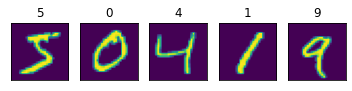

In [ ]:
plot_example(X_train, y_train)

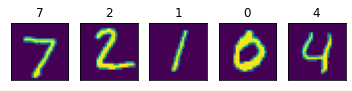

In [ ]:
plot_example(X_test, y_test)

**3.   Construction of base model + Evaluation**

To begin with, a base model will be constructed to serve as a benchmark for future iterations of model building.

Building a base model utilising the sklearn library is quite simple - and will be implemented below. The kernel of choice for this model is the "linear" kernel. It is used when the data is linearly separable, and has the additional advantage of faster training in comparison to other kernels.

In [ ]:
clf = SVC(kernel="linear", random_state=1)

In [ ]:
clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=1)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9404

In [ ]:
# Calculating confusion matrix 
cf = confusion_matrix(y_test, y_pred)

In [ ]:
# Calculating how many times a digit was misclassified
num_misclassified_list = list()
for i in range(cf.shape[0]):
  num_classified = 0
  for j in range(cf.shape[1]):
    if i != j:
      num_classified += cf[i,j]
  num_misclassified_list.append(num_classified)

for i in range(len(num_misclassified_list)):
  print("The digit {} was misclassified {} times".format(i, num_misclassified_list[i]))

print("Total number of misclassified digits: {}".format(sum(num_misclassified_list)))

The digit 0 was misclassified 23 times
The digit 1 was misclassified 13 times
The digit 2 was misclassified 65 times
The digit 3 was misclassified 63 times
The digit 4 was misclassified 40 times
The digit 5 was misclassified 89 times
The digit 6 was misclassified 48 times
The digit 7 was misclassified 71 times
The digit 8 was misclassified 97 times
The digit 9 was misclassified 87 times
Total number of misclassified digits: 596


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


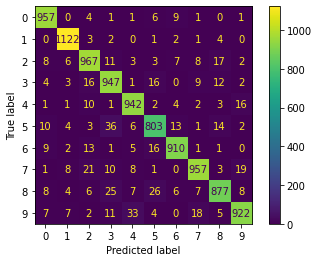

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(clf, X_test, y_test)

In [ ]:
# Observing misclassified images
misclassified_imgs = y_pred != y_test

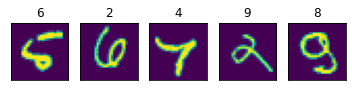

In [ ]:
plot_example(X_test[misclassified_imgs], y_pred[misclassified_imgs])

**4.   Adaptation of hyperparameters + Evaluation**

We will use results from the base run to inform decisions regarding the choice of hyperparameters for this next iteration. It is imperative at this point to understand the objective of SVMs - defining a decision boundary that separate classes. The concept of margins is centered around this degree of separation. Hyperparameter tuning revolves around alterations made to either the decision boundary or margin.


The hyperparameters of interest are:

*   **Kernel** - transforms the input data in order to obtain a better decision boundary. These transformation can be linear. In the case where classes cannot be linearly separated, other functions can be utilised (e.g. polynomial kernel, when this is used, an additional hyperparameter, "degree" can be specified).
*   **C** (regularisation parameter) - indicates the level of importance given to misclassified observations. Higher values of C correspond to a narrower margin, which can result in overfitting. Lower values of C imply a wider margin, which in turn can result in underfitting.
*   **Gamma** - regulates the amount of curvature in the decision boundary. Higher values correspond to more curvature and may lead to overfitting. Lower values imply less curvature, and may result in underfitting, as the decision boundary may fail to capture the complexities within the dataset. 

Given that the base model utilised a linear kernel, we will implement a polynomial kernel (with degree 3, the default value). In addition to this, a lower value for C will be used, and a higher value for gamma. 




In [ ]:
clf2 = SVC(kernel="poly", C = 0.5, gamma = 10)

In [ ]:
clf2.fit(X_train, y_train)

SVC(C=0.5, gamma=10, kernel='poly')

In [ ]:
y_pred2 = clf2.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred2)

0.9787

In [ ]:
# Calculating confusion matrix 
cf2 = confusion_matrix(y_test, y_pred2)

In [ ]:
# Calculating how many times a digit was misclassified
num_misclassified_list = list()
for i in range(cf2.shape[0]):
  num_classified = 0
  for j in range(cf2.shape[1]):
    if i != j:
      num_classified += cf2[i,j]
  num_misclassified_list.append(num_classified)

for i in range(len(num_misclassified_list)):
  print("The digit {} was misclassified {} times".format(i, num_misclassified_list[i]))

print("Total number of misclassified digits: {}".format(sum(num_misclassified_list)))

The digit 0 was misclassified 8 times
The digit 1 was misclassified 9 times
The digit 2 was misclassified 26 times
The digit 3 was misclassified 23 times
The digit 4 was misclassified 17 times
The digit 5 was misclassified 25 times
The digit 6 was misclassified 21 times
The digit 7 was misclassified 28 times
The digit 8 was misclassified 24 times
The digit 9 was misclassified 32 times
Total number of misclassified digits: 213


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


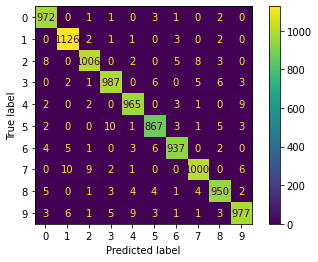

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(clf2, X_test, y_test)

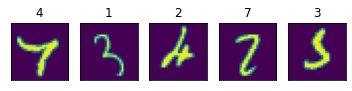

In [ ]:
# Observing misclassified images
misclassified_imgs = y_pred2 != y_test
plot_example(X_test[misclassified_imgs], y_pred2[misclassified_imgs])

We can see a significant improvement in results! The number of misclassified images reduces drastically from 596 to 213. Model accuracy improves from 0.9404 to 0.9787.

**5.   Hyperparameter tuning using Grid Search + Evaluation**

The previous iteration showed that adjusting hyperparameters resulted in improved model performance. We expand this approach by investigating a greater range of values for each hyperparameter in order to obtain optimal results.

Grid search can be an expensive process. Iterating through the learning process with various permutations of hyperparameter values can take significant time. Therefore, grid search will be run on the validation set created in the previous sections. This validation set consists of 6000 images. 

In [ ]:
params = {
    "kernel": ["poly", "rbf"],
    "C": [0.5, 10],
    "gamma": [0.01,10]
}

In [ ]:
model = GridSearchCV(SVC(), params, cv=5)
model.fit(X_val, y_val)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.5, 10], 'gamma': [0.01, 10],
                         'kernel': ['poly', 'rbf']})

In [ ]:
model.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
model.best_score_

0.9570000000000001

**6.   Optimal model construction using grid search results + Evaluation**

Using the results from hyperparameter tuning, we now build an "optimal model", train it on the entire dataset (remember grid search was performed on the validation set) and test. The model will then be saved.

In [ ]:
clf3 = SVC(kernel="rbf", gamma=0.01, C=10)

In [ ]:
clf3.fit(X_train, y_train)

SVC(C=10, gamma=0.01)

In [ ]:
y_pred3 = clf3.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred3)

0.9833

In [ ]:
# Calculating confusion matrix 
cf3 = confusion_matrix(y_test, y_pred3)

In [ ]:
# Calculating how many times a digit was misclassified
num_misclassified_list = list()
for i in range(cf3.shape[0]):
  num_classified = 0
  for j in range(cf3.shape[1]):
    if i != j:
      num_classified += cf3[i,j]
  num_misclassified_list.append(num_classified)

for i in range(len(num_misclassified_list)):
  print("The digit {} was misclassified {} times".format(i, num_misclassified_list[i]))

print("Total number of misclassified digits: {}".format(sum(num_misclassified_list)))

The digit 0 was misclassified 7 times
The digit 1 was misclassified 5 times
The digit 2 was misclassified 18 times
The digit 3 was misclassified 16 times
The digit 4 was misclassified 17 times
The digit 5 was misclassified 20 times
The digit 6 was misclassified 13 times
The digit 7 was misclassified 23 times
The digit 8 was misclassified 21 times
The digit 9 was misclassified 27 times
Total number of misclassified digits: 167


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


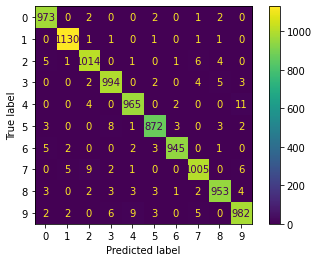

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(clf3, X_test, y_test)

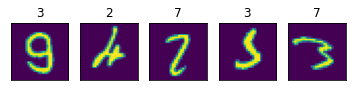

In [ ]:
# Observing misclassified images
misclassified_imgs = y_pred3 != y_test
plot_example(X_test[misclassified_imgs], y_pred3[misclassified_imgs])

We can see an improvement in model performace. The number of misclassified images reduces from 213 to 167. Model accuracy improves from 0.9787 to 0.9833.

In [ ]:
# Save model using pickle
with open("SVM_trained.pkl", "wb") as f:
  pickle.dump(clf3, f)